# What kind of a dog is this?
Final project for Data Science bootcamp organized by Sages.



Importing necessary modules

In [1]:
import os
import time
import timeit
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import imageio
from skimage.transform import resize
from tqdm import tqdm_notebook
from pickle import dump, load

from xml.dom import minidom

import keras
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils

import keras.applications.resnet50 as resnet50
import keras.applications.inception_v3 as inception_v3

from src.yolo_detector import YoloDetector

ModuleNotFoundError: No module named 'livelossplot'

Downloading the data from the website

Loading the data

Initzialization of base global variables

In [2]:
base_folder = 'dataset'
images_path = os.path.join(base_folder, 'Images')
annots_path = os.path.join(base_folder, 'Annotation')
cropps_path = os.path.join(base_folder, 'Cropped')
inception_imagesize = (299,299)
resnet_imagesize = (224,224)
n_classes = 120

In [4]:
#crop_images(images_path, image_size=inception_imagesize) #image size choosen based on required input by Inception model, which is larger than for ResNet

We will use ResNet as a base model

In [4]:
base_resnet = resnet50.ResNet50(weights='imagenet')

# re-structure the model
base_resnet.layers.pop()
base_resnet = Model(inputs=base_resnet.inputs, outputs=base_resnet.layers[-1].output)

# summarize
print(base_resnet.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [5]:
base_inception = inception_v3.InceptionV3(weights='imagenet')

# re-structure the model
base_inception.layers.pop()
base_inception = Model(inputs=base_inception.inputs, outputs=base_inception.layers[-1].output)

# summarize
print(base_inception.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
def extract_feature(filename, model, app, image_size):
    # load an image from file
    img = image.load_img(filename, target_size=image_size)
    img = image.img_to_array(img)

    # reshape data for the model and preprocess for the ResNet model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = app.preprocess_input(img)

    #get image features
    return model.predict(img, verbose=0)

def extract_features(base_path, model, app, image_size):
    features = dict()
    
    files_list = [os.path.join(dirpath, filename) 
                  for dirpath, dirs, filenames in os.walk(base_path) 
                  for filename in filenames if not filename.startswith('.')
                 ]
    
    #temp variables for batch dumping features to file
    #and keeping track of already processed files 
    i = 0
    processed_files = []
    for filename in tqdm_notebook(files_list):
        if not filename.startswith('.'):
            
            feature = extract_feature(filename, model, app, image_size)
            
            #store feature
            image_id = filename.split('/')[-1].split('.')[0]
            features[image_id] = feature
            
            #update progress counter and once per 500 rounds make features dump
            i += 1
            if i%500 == 0:
                dump(features, open('temp_features.pkl', 'wb'))
            
    dump(features, open('temp_features.pkl', 'wb'))
    
    return features, processed_files

In [13]:
#resnet_features, resnet_processed_files = extract_features(cropps_path, base_resnet, app=resnet50, image_size=resnet_imagesize)
#print('Extracted Features: %d' % len(resnet_features))
# save to file
#dump(resnet_features, open('resnet_features.pkl', 'wb'))


Extracted Features: 20580


In [14]:
#inception_features, inception_processed_files = extract_features(cropps_path, base_inception, app=inception_v3, image_size=inception_imagesize)
#print('Extracted Features: %d' % len(inception_features))
# save to file
#dump(inception_features, open('inception_features.pkl', 'wb'))


Extracted Features: 20580


In [7]:
def load_features(filename):
    with open(filename, 'rb') as features_file:
        features = load(features_file)

    return features

## Data loading and train - test split methods

Below are three metods used for loading the data from .mat files, then extrating necessery information from the loaded files, 

In [8]:
def extract_data(arr):
    train_data = []
    for data in arr:
        path = data[0][0].split('/')
        idx = path[1]
        label = path[0].split('-')[1].lower()
        train_data.append([idx, label])
        
    return np.array(train_data)

In [9]:
def load_data():
    train_file = sio.loadmat('dataset/train_list.mat')
    test_file = sio.loadmat('dataset/test_list.mat')
    
    train_data = extract_data(train_file['annotation_list'])
    test_data = extract_data(test_file['annotation_list'])
    
    full_data = np.append(train_data[:,1], test_data[:,1])
    labels_coding = {label:id_int for id_int,label in enumerate(np.unique(full_data))}
    
    return train_data, test_data, labels_coding

In [10]:
def prepare_train_test_data(features, train_data, test_data, labels_coding):
    X_train = np.array([features[i][0] for i in train_data[:,0]])
    y_train = np_utils.to_categorical([labels_coding[k] for k in train_data[:,1]])
    X_test = np.array([features[i][0] for i in test_data[:,0]])
    y_test = np_utils.to_categorical([labels_coding[k] for k in test_data[:,1]])
    
    return X_train, X_test, y_train, y_test

In [11]:
train_data, test_data, labels_coding = load_data()

## Model Definition

In [12]:
def define_model():
    model = Sequential()
    
    #input shape based on the output layer from ResNet50 and Inception models
    model.add(Dense(2048, activation='relu', input_shape=(2048,)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    #output layer
    model.add(Dense(n_classes, activation='softmax')) #n_classes from global parameters, n_classes = 120
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) 
    print(model.summary())
    
    return model

In [13]:
batch_size = 32

In [14]:
def get_checkpoint(model_name):
    checkpoint_path = 'checkpoints/' + model_name + '-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
    return ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)

In [15]:
early_stopping = EarlyStopping(patience=20, monitor='val_loss')

## Fitting model based on features generated by ResNet model

In [16]:
def train_model(features, train_data, test_data, labels_coding, checkpoint):
    X_train, X_test, y_train, y_test = prepare_train_test_data(features, train_data, test_data, labels_coding)

    model = define_model()
    history = model.fit(X_train, y_train, 
                               validation_data=(X_test, y_test), 
                               epochs=1000, 
                               callbacks=[early_stopping, checkpoint], 
                               batch_size=batch_size)
    return model, history

In [17]:
resnet_checkpoint = get_checkpoint('resnet')
resnet_features = load_features('data/resnet_features.pkl')

resnet_model, resnet_history = train_model(resnet_features, train_data, test_data, labels_coding, resnet_checkpoint)
dump(resnet_history.history, open('data/resnet_history.pkl', 'wb'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               123000    
Total params: 6,417,528
Trainable params: 6,417,528
Non-trainable params: 0
_________________________________________________________________
None
Train on 12000 samples, validate on 8580 samples
Epoch 1/1000
12000/12000 [==============================] - 20s 2ms/step - los

## Fitting model based on features generated by Inception model

In [18]:
inception_checkpoint = get_checkpoint('inception')
inception_features = load_features('inception_features.pkl')

inception_model, inception_history = train_model(inception_features, train_data, test_data, labels_coding, inception_checkpoint)

dump(inception_history.history, open('inception_history.pkl', 'wb'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               123000    
Total params: 6,417,528
Trainable params: 6,417,528
Non-trainable params: 0
_________________________________________________________________
None
Train on 12000 samples, validate on 8580 samples
Epoch 1/1000
12000/12000 [==============================] - 20s 2ms/step - los

## Comparision

### Visual Comparision

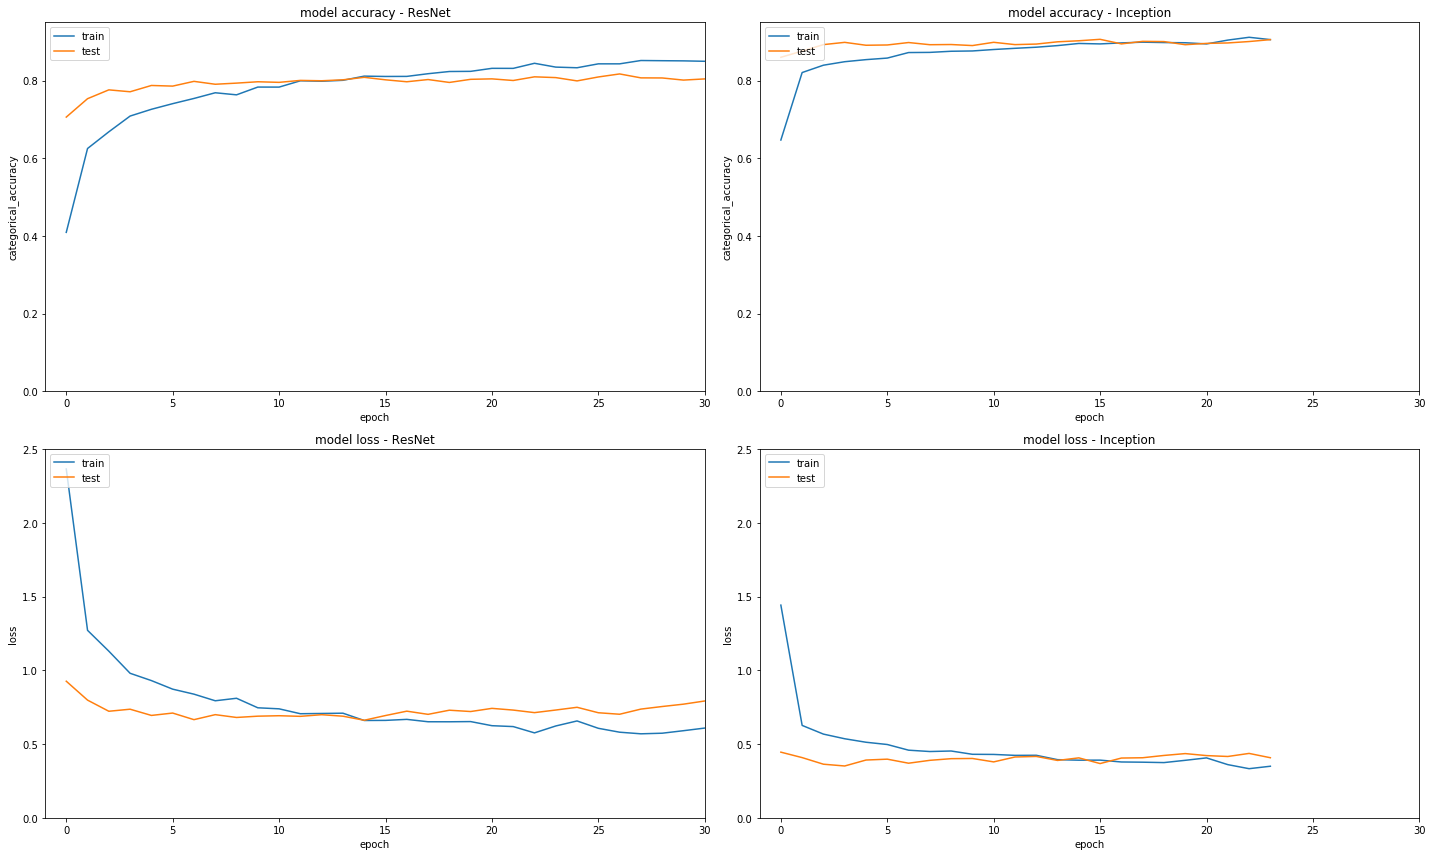

In [19]:
fig = plt.figure(figsize=(20,12))

# summarize history for accuracy resnet
plt.subplot(2, 2, 1)
plt.axis([-1,30, 0,0.95])
plt.plot(resnet_history.history['categorical_accuracy'])
plt.plot(resnet_history.history['val_categorical_accuracy'])
plt.title('model accuracy - ResNet')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


# summarize history for accuracy inception
plt.subplot(2, 2, 2)
plt.axis([-1,30, 0,0.95])
plt.plot(inception_history.history['categorical_accuracy'])
plt.plot(inception_history.history['val_categorical_accuracy'])
plt.title('model accuracy - Inception')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss resnet
plt.subplot(2, 2, 3)
plt.axis([-1,30, 0,2.5])
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('model loss - ResNet')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


# summarize history for loss inception
plt.subplot(2, 2, 4)
plt.axis([-1,30, 0,2.5])
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('model loss - Inception')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

## Load best parameters for each model

In [20]:
# TODO: load best parameters

## Making predictions

Class used as a wrapper on Yolo detection system[3][4]. 

In [128]:
class YoloDetector(): 
    def __init__(self, obj_threshold=0.6, nms_threshold=0.5, classes_file='YOLOv3/data/coco_classes.txt'):
        self.yolo = YOLO(obj_threshold, nms_threshold, 'YOLOv3/data/yolo.h5')
        self.all_classes = self.get_classes(classes_file)

    def get_classes(self, file):
        """Get classes name.

        # Argument:
            file: classes name for database.

        # Returns
            class_names: List, classes name.

        """
        with open(file) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]

        return class_names

    def process_image(self, img):
        """Resize, reduce and expand image.

        # Argument:
            img: original image.

        # Returns
            image: ndarray(64, 64, 3), processed image.
        """
        image = cv2.resize(img, (416, 416),
                           interpolation=cv2.INTER_CUBIC)
        image = np.array(image, dtype='float32')
        image /= 255.
        image = np.expand_dims(image, axis=0)

        return image
    
    def draw(self, image, boxes, scores, classes, all_classes):
        """Draw the boxes on the image.

        # Argument:
            image: original image.
            boxes: ndarray, boxes of objects.
            classes: ndarray, classes of objects.
            scores: ndarray, scores of objects.
            all_classes: all classes name.
        """
        for box, score, cl in zip(boxes, scores, classes):
            x, y, w, h = box

            top = max(0, np.floor(x + 0.5).astype(int))
            left = max(0, np.floor(y + 0.5).astype(int))
            right = min(image.shape[1], np.floor(x + w + 0.5).astype(int))
            bottom = min(image.shape[0], np.floor(y + h + 0.5).astype(int))

            cv2.rectangle(image, (top, left), (right, bottom), (255, 0, 0), 2)
            cv2.putText(image, '{0} {1:.2f}'.format(all_classes[cl], score),
                        (top, left - 6),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, (0, 0, 255), 1,
                        cv2.LINE_AA)

            print('class: {0}, score: {1:.2f}'.format(all_classes[cl], score))
            print('box coordinate x,y,w,h: {0}'.format(box))
        plt.imshow(image)
        print()

    def detect_image(self, image):
        """Use yolo v3 to detect images.

        # Argument:
            image: original image.
            yolo: YOLO, yolo model.
            all_classes: all classes name.

        # Returns:
            image: processed image.
        """
        pimage = self.process_image(image)

        boxes, classes, scores = self.yolo.predict(pimage, image.shape)

        return boxes, classes, scores
    
    def detect(self, image):
        #image = cv2.imread(image_path)
        boxes, classes, scores = self.detect_image(image)
        return boxes, classes, scores

In [4]:

detector = YoloDetector()

ModuleNotFoundError: No module named 'yolo_detector'

In [256]:
def predict_for_file(file_path, model, detector=None, verbose=0):
    if verbose: print("Loading image...")
    img = imageio.imread(file_path, pilmode='RGB')
    if verbose: print("Loaded. Detecting dogs...")
    if detector:
        boxes, classes, scores = detector.detect(img)

        #TODO: Check if dog

        x, y, w, h = boxes[0]
        top = max(0, np.floor(x + 0.5).astype(int))
        left = max(0, np.floor(y + 0.5).astype(int))
        right = min(img.shape[1], np.floor(x + w + 0.5).astype(int))
        bottom = min(img.shape[0], np.floor(y + h + 0.5).astype(int))

        if verbose: detector.draw(np.copy(img), boxes, scores, classes, detector.all_classes)
        if verbose: print("Dog detected. Checking breed...")
        img = img[left:bottom,top:right]
    else:
        if verbose: plt.imshow(img)
        
    img = resize(img, inception_imagesize, preserve_range=True).astype('uint8')
    img = keras.preprocessing.image.img_to_array(img)
    # reshape data for the model and preprocess for the model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = inception_v3.preprocess_input(img)

    #get image features
    features = base_inception.predict(img, verbose=0)
    pred = model.predict(features)[0]

    #return scores above 0.01 as array of label and probability
    if np.any(pred > 0.1):
        probas = zip(np.where(pred > 0.1)[0], np.take(pred, np.where(pred > 0.1)[0]))
    else:
        highest_indexes = pred.argsort()[-5:][::-1]
        probas = zip(highest_indexes, np.take(pred, highest_indexes))
    
    labeled_probas = [[get_key_by_value(labels_coding, k),v] 
                   for k,v in probas
                  ]
    labeled_probas.sort(key=lambda x: x[1], reverse=True)
    return labeled_probas

In [ ]:
def compare_for_test_images(models, detector):
    results = []
    for entry in os.scandir('test_images'):
        if not entry.name.startswith('.') and entry.is_file():
            for model in models:
                time_with_detector = timeit.timeit('preds_detector = predict_for_file(entry.path, model, detector)')
                time_without_detector = timeit.timeit('preds_without_detector = predict_for_file(entry.path, model)')
                
                results.append({
                    'file': entry.path
                    'model': model,
                    'preds_detector': preds_detector
                    'preds_without_detector': preds_without_detector
                    'time_with_detector': time_with_detector 
                    'time_without_detector': time_without_detector
                })
    
    return results

[['bluetick', 1.0]]

In [258]:
predict_for_file('test_images/bluetick.jpg', resnet_model, detector)

[['labrador_retriever', 0.021352388],
 ['staffordshire_bullterrier', 0.021170301],
 ['appenzeller', 0.020607455],
 ['black', 0.020483099],
 ['flat', 0.019207023]]

In [ ]:
def get_key_by_value(d, value):
    for k, v in d.items():
        if v == value:
            return k

#y_class_id = [np.argmax(y, axis=None, out=None) for y in y_test]

#y_class = [get_key_by_value(labels_coding, class_id) for class_id in y_class_id]

Reversing categorical to class number

# References


Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei.**Novel dataset for Fine-Grained Image Categorization.**_First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR)_, 2011.  [\[pdf\]](http://people.csail.mit.edu/khosla/papers/fgvc2011.pdf)  [\[poster\]](http://vision.stanford.edu/documents/KhoslaJayadevaprakashYaoFeiFei_FGVC2011.pdf)  [\[BibTex\]](http://vision.stanford.edu/bibTex/KhoslaJayadevaprakashYaoFeiFei_FGVC2011.bib)

J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li and L. Fei-Fei,**ImageNet: A Large-Scale Hierarchical Image Database.**_IEEE Computer Vision and Pattern Recognition (CVPR)_, 2009.  [\[pdf\]](http://www.image-net.org/papers/imagenet_cvpr09.pdf)  [\[BibTex\]](http://www.image-net.org/papers/imagenet_cvpr09.bib)

https://github.com/xiaochus/YOLOv3